In [1]:
import torch
import blobfile as bf
from transformer_lens import HookedTransformer
import sparse_autoencoder
from typing import List, Tuple, Dict
from functools import lru_cache
from torch import nn 
import json
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
import random
import transformer_lens.utils as utils
import torch.nn.functional as F
import pandas as pd



In [2]:
import gc

def print_gpu_memory():
    # Print total memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB")
    
    # Print allocated memory
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    
    # Print cached memory
    print(f"Cached GPU memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# Clear memory before loading
torch.cuda.empty_cache()
gc.collect()
print("\nBefore loading model:")
print_gpu_memory()


Before loading model:
Total GPU memory: 8113.81 MB
Allocated GPU memory: 0.00 MB
Cached GPU memory: 0.00 MB


### Plotting helpers

In [3]:
import plotly.express as px
import plotly.io as pio

In [4]:
from functools import partial
from typing import List, Optional, Union

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [5]:
def imshow(tensor, color_midpoint=0, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=color_midpoint,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

### Dataset Load/Cleanup

In [6]:
dataset_name = "ml" #"lgd"

In [7]:
if dataset_name == "lgd":
    with open('/home/chiragr2/CausalProbe/sparse_autoencoder/pipeline_artefacts/lgd/s1_specific_data_clean.json', 'r') as file:
        data = json.load(file)
if dataset_name == "ml":
    with open('/home/chiragr2/CausalProbe/sparse_autoencoder/pipeline_artefacts/marvin_linzen/s1_specific_data_clean_ma_lin.json', 'r') as file:
        data = json.load(file)

In [8]:
for i,data_pt in enumerate(data):
    mask_index = data_pt["causal1"]['orig'].find(" "+data_pt["causal1"]['trg_wd']) + len(data_pt["causal1"]['trg_wd'])+1
    data[i]["causal1"]['orig'] = data_pt["causal1"]['orig'][:mask_index]

    mask_index = data_pt["causal2"]['orig'].find(" "+data_pt["causal2"]['trg_wd']) + len(data_pt["causal2"]['trg_wd'])+1
    data[i]["causal2"]['orig'] = data_pt["causal2"]['orig'][:mask_index]

In [9]:
model = HookedTransformer.from_pretrained("gpt2-small", center_writing_weights=False)
device = next(model.parameters()).device

/home/chiragr2/CausalProbe/venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [10]:
lengths_dict = {}
for data_pt in data:
    sentence = data_pt['causal1']['orig']
    tokens= model.to_tokens(sentence)[0]
    if len(tokens) not in lengths_dict.keys():
        lengths_dict[len(tokens)] = 1
    else:
        lengths_dict[len(tokens)] +=1
    
lengths_dict

{4: 50, 7: 18051, 9: 7354, 8: 17912, 10: 1782, 11: 315, 6: 5586}

In [11]:
filtered_data = []
num_tokens = 9
tokens = []
for i,data_pt in enumerate(data):
    tokens1= model.to_tokens(data_pt['causal1']['orig'])[0]
    tokens2= model.to_tokens(data_pt['causal2']['orig'])[0]
    # print("tokens:", len(tokens))
    if len(tokens1) == num_tokens and len(tokens2) == num_tokens and data_pt['envir1']['val'] == 1: # choosing len 9 for this analysis and envirn vars
        filtered_data.append(data_pt)
        tokens.append(tokens1)
        tokens.append(tokens2)
data = filtered_data
filtered_data = [] #just a little clean up

In [12]:
len(data)

1130

In [13]:
tokens = torch.stack(tokens)

In [16]:
data[0]

{'causal1': {'orig': 'the author next to the security guard laughs',
  'mask': 'the author next to the security guard [MASK]',
  'trg_wd': 'laughs',
  'trg_wd_flip': 'laugh',
  'label': True,
  'trg2_wd': None,
  'trg2_wd_flip': None},
 'causal2': {'orig': 'the authors next to the security guard laugh',
  'mask': 'the authors next to the security guard [MASK]',
  'trg_wd': 'laugh',
  'trg_wd_flip': 'laughs',
  'label': False,
  'trg2_wd': None,
  'trg2_wd_flip': None},
 'other': {'sent_type': 'prep_anim_sing',
  'cue_idx': 1,
  'trg1_idx': 7,
  'trg2_idx': None},
 'envir1': {'name': 'attractor_num',
  'val': 1,
  'orig_sg_flip': 'the author next to the security guards laughs',
  'orig_pl_flip': 'the authors next to the security guards laugh',
  'mask_sg_flip': 'the author next to the security guards [MASK]',
  'mask_pl_flip': 'the authors next to the security guards [MASK]'}}

In [17]:
if dataset_name == "lgd":
    sentence = data[0]['causal']['orig']
    vocab_options = [data[0]['causal']['trg_wd'], data[0]['causal']['trg_wd_flip']]
else:
    sentence = data[0]['causal1']['orig']
    vocab_options = [data[0]['causal1']['trg_wd'], data[0]['causal1']['trg_wd_flip']]

print("Sentence:", sentence)
print("Vocab options:", vocab_options)

layer_index=11
location = "resid_post_mlp"     # we will inject our edited activation here

vocab_ids = [model.to_tokens(f" {word}")[0, 1] for word in vocab_options]
print("Vocab token IDs:", vocab_ids)

tokens_1= model.to_tokens(sentence)[0][:-1]
mask_position=len(tokens_1)                 # the token position where we want to “mask” or edit

with torch.no_grad():
    out, activation_cache = model.run_with_cache(tokens_1, remove_batch_dim=True)

hook_name = {
    "mlp_post_act": f"blocks.{layer_index}.mlp.hook_post",
    "resid_delta_attn": f"blocks.{layer_index}.hook_attn_out",
    "resid_post_attn": f"blocks.{layer_index}.hook_resid_mid",
    "resid_delta_mlp": f"blocks.{layer_index}.hook_mlp_out",
    "resid_post_mlp": f"blocks.{layer_index}.hook_resid_post",
}[location]

input_tensor = activation_cache[hook_name]

Sentence: the author next to the security guard laughs
Vocab options: ['laughs', 'laugh']
Vocab token IDs: [tensor(22051, device='cuda:0'), tensor(6487, device='cuda:0')]


In [20]:
vocab_ids

[tensor(22051, device='cuda:0'), tensor(6487, device='cuda:0')]

In [21]:
tokens

tensor([[50256,  1169,  1772,  ...,  2324,  4860, 22051],
        [50256,  1169,  7035,  ...,  2324,  4860,  6487],
        [50256,  1169,  1772,  ...,  2324,  4860,   318],
        ...,
        [50256,  1169, 29597,  ..., 17536,  4639,   389],
        [50256,  1169, 17028,  ..., 17536,  4639,   318],
        [50256,  1169, 29597,  ..., 17536,  4639,   389]], device='cuda:0')

In [22]:
logits = model(tokens_1)
final_position_logits = logits[0][-1]
filtered_logits = torch.tensor([final_position_logits[vocab_ids[0].item()], final_position_logits[vocab_ids[1].item()]])
print(filtered_logits)

tensor([5.5696, 4.1495])


In [23]:
# print_gpu_memory()

In [24]:
# Get the top 10 logits and their corresponding indices
topk_values, topk_indices = torch.topk(final_position_logits, k=10)

# Loop through the top predictions and print the token (using model.to_string) and its logit value
for logit, token_idx in zip(topk_values, topk_indices):
    token_str = model.to_string(token_idx.item())
    print(f"Token: {token_str} | Logit: {logit.item()}")

Token:  at | Logit: 13.84525203704834
Token: . | Logit: 13.535942077636719
Token:  in | Logit: 13.458696365356445
Token: , | Logit: 13.352209091186523
Token:  who | Logit: 13.101161003112793
Token:  on | Logit: 12.70655632019043
Token: 
 | Logit: 12.683555603027344
Token:  and | Logit: 12.635149955749512
Token: 's | Logit: 12.19099235534668
Token:  is | Logit: 12.115265846252441


### Load SAE

In [25]:
def load_sae(location, layer_index):    
    with bf.BlobFile(sparse_autoencoder.paths.v5_32k(location, layer_index), mode="rb") as f:
        state_dict = torch.load(f)
        autoencoder = sparse_autoencoder.Autoencoder.from_state_dict(state_dict)
        autoencoder.to(device)
    return autoencoder

In [26]:
autoencoder = load_sae("resid_post_mlp", 10)

In [27]:
# for piece in activation_cache:
#     print(piece, " ", activation_cache[piece].shape)

In [28]:
hook_name

'blocks.11.hook_resid_post'

In [29]:
input_tensor = activation_cache[hook_name]

input_tensor_ln = input_tensor

with torch.no_grad():
    latent_activations, info = autoencoder.encode(input_tensor_ln)
    reconstructed_activations = autoencoder.decode(latent_activations, info)

normalized_mse = (reconstructed_activations - input_tensor).pow(2).sum(dim=1) / (input_tensor).pow(2).sum(dim=1)
print(location, normalized_mse)

resid_post_mlp tensor([0.1293, 0.3895, 0.3723, 0.3611, 0.3703, 0.3540, 0.2931, 0.3389],
       device='cuda:0')


In [30]:
reconstructed_activation = reconstructed_activations[-1]

In [31]:
mask_logits = logits[0][-1]  # shape: (vocab_size,)

# 6. Filter the logits to only your limited vocabulary options.
filtered_logits = torch.tensor([mask_logits[vocab_ids[0].item()], mask_logits[vocab_ids[1].item()]])
print(filtered_logits)

# 7. Predict the token (choosing the vocab option with the highest logit).
predicted_idx = torch.argmax(filtered_logits)
predicted_token_id = vocab_ids[predicted_idx]
predicted_token_str = model.to_string(predicted_token_id)

print("Predicted token:", predicted_token_str)

tensor([5.5696, 4.1495])
Predicted token:  laughs


In [32]:
#MSE for final activation layer
(reconstructed_activations[-1] - input_tensor[-1]).pow(2).sum(dim=0) / (input_tensor[-1]).pow(2).sum(dim=0)

tensor(0.3389, device='cuda:0')

In [33]:
input_tensor.shape

torch.Size([8, 768])

In [34]:
reconstructed_activations

tensor([[ 2.4971,  1.7496, -0.1007,  ...,  3.3681,  0.5856, -0.2428],
        [ 4.3674, -4.8118,  3.7892,  ..., -8.0202, -0.5741, -6.3610],
        [ 2.4579, -2.0274,  0.7983,  ..., -7.8389, -1.4257, -1.7937],
        ...,
        [ 3.2350, -2.4091,  2.8396,  ..., -5.7023, -1.6507, -5.8529],
        [ 3.5274,  0.6013,  0.4663,  ..., -4.7240,  2.4274, -3.2330],
        [ 4.1292,  0.7783,  3.8506,  ..., -5.2894,  0.0748, -2.5547]],
       device='cuda:0')

### Inject reconstruction or intervention

In [53]:
def injection_hook(res, hook):
    print(f"MSE: { ( (reconstructed_activations[-1] - res[0][-1]).pow(2).sum(dim=0) / (res[0][-1]).pow(2).sum(dim=0) ) }")
    res[0][mask_position-1] = reconstructed_activations[mask_position-1]
    return res


hook_key = f"blocks.{layer_index}.hook_resid_post"  # for location "resid_post_mlp"
print(hook_key)
# with torch.no_grad():
    # run_with_hooks runs the model and applies our injection at the chosen layer.
logits = model.run_with_hooks(tokens_1, fwd_hooks=[(hook_key, injection_hook)])

mask_logits = logits[0][mask_position-1]  # shape: (vocab_size,)

filtered_logits = torch.tensor([mask_logits[vocab_ids[0].item()], mask_logits[vocab_ids[1].item()]])
print(filtered_logits)

# 7. Predict the token (choosing the vocab option with the highest logit).
predicted_idx = torch.argmax(filtered_logits)
predicted_token_id = vocab_ids[predicted_idx]
predicted_token_str = model.to_string(predicted_token_id)

print("Predicted token:", predicted_token_str)


blocks.11.hook_resid_post
MSE: 0.5192175507545471
tensor([4.5855, 5.3319])
Predicted token:  laugh


# Train probes

In [36]:
# dataset = load_dataset("fahamu/ioi", data_files={"train": "mecha_ioi_200k.parquet"})
# dataset = load_dataset("danaarad/ioi_dataset")

In [37]:
# dataset['train']

In [41]:
data[100]

{'causal1': {'orig': 'the pilot in front of the assistant laughs',
  'mask': 'the pilot in front of the assistant [MASK]',
  'trg_wd': 'laughs',
  'trg_wd_flip': 'laugh',
  'label': True,
  'trg2_wd': None,
  'trg2_wd_flip': None},
 'causal2': {'orig': 'the pilots in front of the assistant laugh',
  'mask': 'the pilots in front of the assistant [MASK]',
  'trg_wd': 'laugh',
  'trg_wd_flip': 'laughs',
  'label': False,
  'trg2_wd': None,
  'trg2_wd_flip': None},
 'other': {'sent_type': 'prep_anim_sing',
  'cue_idx': 1,
  'trg1_idx': 7,
  'trg2_idx': None},
 'envir1': {'name': 'attractor_num',
  'val': 1,
  'orig_sg_flip': 'the pilot in front of the assistants laughs',
  'orig_pl_flip': 'the pilots in front of the assistants laugh',
  'mask_sg_flip': 'the pilot in front of the assistants [MASK]',
  'mask_pl_flip': 'the pilots in front of the assistants [MASK]'}}

In [35]:
def tokenize(data, ml_num):

    y = 0

    sentence = data[f'causal{ml_num}']['orig']

    vocab_options = [data[f'causal{ml_num}']['trg_wd'], data[f'causal{ml_num}']['trg_wd_flip']]

    if data[f'causal{ml_num}']['label']: # different for lgd
        y = 1

    location = "resid_post_mlp"     # we will inject our edited activation here

    vocab_ids = [model.to_tokens(f" {word}")[0, 1] for word in vocab_options]

    tokens = model.to_tokens(sentence)[0]

    for i,tok in enumerate(tokens):
        if tok == vocab_ids[0]:
            mask_position = i

    with torch.no_grad():
        _, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)

    return activation_cache, mask_position, y, torch.tensor(vocab_ids)

def ioi_tokenize(data,layer_index, cf_num):

    # cf_label = f"s{cf_num}_io_flip_counterfactual"
    # sentence = data[cf_label]['prompt']
    values = {
        "name_A": "Rod",
        "name_B": "Luke",
        "place": data['metadata']['place'],
        "name_C": "Luke",
        "object": data['metadata']['object']
    }
    if cf_num:
        values["name_C"]= "Rod"
    sentence = data['template'].format(**values)

    y= cf_num

    # y = data[cf_label]['answerKey']
    # print("Sentence:", sentence)

    location = "resid_post_mlp"     # we will inject our edited activation here

    tokens = model.to_tokens(sentence)

    with torch.no_grad():
        _, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)

    hook_name = {
        "mlp_post_act": f"blocks.{layer_index}.mlp.hook_post",
        "resid_delta_attn": f"blocks.{layer_index}.hook_attn_out",
        "resid_post_attn": f"blocks.{layer_index}.hook_resid_mid",
        "resid_delta_mlp": f"blocks.{layer_index}.hook_mlp_out",
        "resid_post_mlp": f"blocks.{layer_index}.hook_resid_post",
    }[location]

    input_tensor = activation_cache[hook_name]

    return input_tensor, len(tokens[0]), y

In [36]:
num_examples = len(data)
num_layers = model.cfg.n_layers
# num_tokens 
hidden_dim = 768  # Standard hidden dimension

In [68]:
all_embeddings = torch.zeros((num_tokens, num_layers, 2*num_examples, hidden_dim), device=device, dtype=torch.float32)
y = torch.zeros(2*num_examples, device=device, dtype=torch.float32)
mask_positions = torch.zeros(2*num_examples, dtype=torch.long, device=device)
all_vocab_ids = torch.zeros(2*num_examples, 2, dtype=torch.long, device=device)

for i,data_pt in enumerate(data[:num_examples]):
    for j in range(0,2):
        index = 2*i+j
        activation_cache, mask_positions[index], y[index], all_vocab_ids[index] = tokenize(data_pt, j+1) # 0 is plural for now
        for layer_index in range(num_layers):
            hook_name = f"blocks.{layer_index}.hook_resid_post"
            embedding = activation_cache[hook_name]
            all_embeddings[:, layer_index, index, :] = embedding

    if i%50 == 0:
        print(i)

# for tok_pos in range(num_tokens):
#     embeddings[tok_pos] = torch.stack(embeddings[tok_pos], dim=0)
    # embeddings = torch.stack(embeddings, dim=0)
# y = torch.tensor(y)
print(all_embeddings.shape, y.shape)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
torch.Size([9, 12, 2260, 768]) torch.Size([2260])


In [70]:
# torch.allclose(all_embeddings[:-1, 11, 0, :],input_tensor, rtol=0.0001, atol=0.0001)

In [ ]:
# from itertools import islice

In [ ]:
# embeddings = []
# y = []
# mask_positions = []
# layer_index = 8
# for count,data_pt in enumerate(islice(iter(dataset['train']), 500)):
#     for i in range(2):
#         embedding, mask_position, y_rand = ioi_tokenize(data_pt, layer_index, i)
#         embeddings.append(embedding[mask_position-1])
#         mask_positions.append(mask_position)
#         y.append(y_rand)
#     if count%100 == 0:
#         print(count)
# embeddings = torch.stack(embeddings, dim=0)
# y = torch.tensor(y)
# print(embeddings.shape, y.shape)

In [ ]:
# len(dataset['train'])

In [72]:
e_copy = all_embeddings.clone()
y_copy = y.clone()
all_vocab_ids_copy = all_vocab_ids.clone()

In [73]:
# Saving multiple tensors in one file
torch.save({
    'embeddings': e_copy,
    'labels': y_copy,
    'mask_positions': mask_positions,
    'vocab_ids': all_vocab_ids_copy,
}, './tensors.pt')

In [268]:
# Loading the tensors
checkpoint = torch.load('tensors.pt', map_location=torch.device(device))
all_embeddings = checkpoint['embeddings']
all_vocab_ids = checkpoint['vocab_ids']
y = checkpoint['labels']
mask_positions = checkpoint['mask_positions']

In [269]:
from src.probe import find_best_probe

In [270]:
param_grid = {
    'n_layers': [1, 2],
    'layer_size': [1, 128, 256, 384],
    'loss_fn': [nn.CrossEntropyLoss()],#[nn.BCEWithLogitsLoss()],#, nn.MSELoss()],
    'learning_rate': [0.001],#, 0.01 0.1]
}
batch_size = 20

In [271]:
percent_80_emb = round(len(y)*0.8)
test_y = y[percent_80_emb:]
y = y[:percent_80_emb]

In [272]:
val_accuracy = torch.zeros((num_tokens, num_layers), device=device, dtype=torch.float32)

In [273]:
all_embeddings.shape

torch.Size([9, 12, 2260, 768])

In [274]:
experimental_tok_pos = 7
experimental_layer_index = 10

for tok_pos in range(num_tokens):
    for layer_index in range(num_layers):

        tok_pos = experimental_tok_pos
        layer_index = experimental_layer_index

        print("token: ", tok_pos, " layer: ",layer_index)

        embeddings = all_embeddings[tok_pos, layer_index, :, :]
        # tok_pos = 8
        print(tok_pos)
        test_embeddings = embeddings[percent_80_emb:]
        embeddings = embeddings[:percent_80_emb]

        print(embeddings.shape, y.shape)
        print(test_embeddings.shape, test_y.shape)

        probe, criterion = find_best_probe(embeddings, y, test_embeddings, test_y, param_grid, batch_size, criterion='val acc', do_print=True, do_tqdm=True)

        val_accuracy[tok_pos, layer_index] = criterion

        break
    break

token:  7  layer:  10
7
torch.Size([1808, 768]) torch.Size([1808])
torch.Size([452, 768]) torch.Size([452])
Train, test num. examples: 1808 452
{'n_layers': 1, 'layer_size': 1, 'dims': [768, 1, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


/home/chiragr2/CausalProbe/sparse_autoencoder/src/probe.py:217: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



  0%|          | 0/8 [00:00<?, ?it/s]

val acc 0.5
{'n_layers': 2, 'layer_size': 1, 'dims': [768, 1, 1, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 0.5
{'n_layers': 1, 'layer_size': 128, 'dims': [768, 128, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 1.0
{'n_layers': 2, 'layer_size': 128, 'dims': [768, 128, 128, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 1.0
{'n_layers': 1, 'layer_size': 256, 'dims': [768, 256, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 1.0
{'n_layers': 2, 'layer_size': 256, 'dims': [768, 256, 256, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 1.0
{'n_layers': 1, 'layer_size': 384, 'dims': [768, 384, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 1.0
{'n_layers': 2, 'layer_size': 384, 'dims': [768, 384, 384, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


  0%|          | 0/8 [00:00<?, ?it/s]

val acc 1.0
Best val acc: 1.0 with parameters {'n_layers': 2, 'layer_size': 384, 'dims': [768, 384, 384, 2], 'epochs': 8, 'save_criterion': 'val acc', 'loss_fn': CrossEntropyLoss(), 'learning_rate': 0.001}


In [48]:
probe(embeddings)[0:5]

tensor([[ -8.1299,   7.3746],
        [ 10.4603, -11.0354],
        [ -8.1299,   7.3746],
        [ 10.4603, -11.0354],
        [ -8.1299,   7.3746]], device='cuda:0', grad_fn=<SliceBackward0>)

In [49]:
round(len(embeddings)*0.8)

1446

In [50]:
# percent_80_emb = round(len(embeddings)*0.8)
# test_embeddings = embeddings[percent_80_emb:]
# test_y = y[percent_80_emb:]
# embeddings = embeddings[:percent_80_emb]
# y = y[:percent_80_emb]

In [51]:
y.shape

torch.Size([1808])

### INLP

In [52]:
from collections import Counter
def majority_accuracy(labels):
    return Counter(labels).most_common(1)[0][1] / len(labels)

In [53]:
from tasks.utils import get_projection_matrix

In [251]:
num_clfs = 20  # max number of classifiers to train; p may be proj from clf < 30 or num of dims to remove
maj_acc = majority_accuracy(y.cpu().detach().numpy())
print("maj_acc",maj_acc)
print(test_embeddings.shape)
print(embeddings.shape)
final_p, all_ps, (p, n_coords) = get_projection_matrix(
        num_clfs, embeddings, y, test_embeddings, test_y, majority_acc=maj_acc, pth="/home/chiragr2/CausalProbe/sparse_autoencoder/pipeline_artefacts", property=None)
print('Done!')

maj_acc 0.5
torch.Size([452, 768])
torch.Size([2260, 768])
iteration: 0, accuracy: 1.0
iteration: 1, accuracy: 0.9004424778761062
iteration: 2, accuracy: 0.5442477876106194
iteration: 3, accuracy: 0.5
projection saved timestamp: 3
iteration: 4, accuracy: 0.5
iteration: 5, accuracy: 0.5
iteration: 6, accuracy: 0.5
iteration: 7, accuracy: 0.5
iteration: 8, accuracy: 0.5
iteration: 9, accuracy: 0.5
iteration: 10, accuracy: 0.5
iteration: 11, accuracy: 0.4889380530973451
iteration: 12, accuracy: 0.5
iteration: 13, accuracy: 0.5
iteration: 14, accuracy: 0.5
iteration: 15, accuracy: 0.5
iteration: 16, accuracy: 0.5
iteration: 17, accuracy: 0.5
iteration: 18, accuracy: 0.5
iteration: 19, accuracy: 0.5
Done!


In [253]:
intervened_embeddings = embeddings @ torch.from_numpy(p).to(device).float()

In [221]:
probe(embeddings)

tensor([[-10.7792,  11.7483],
        [ 10.9950, -10.5135],
        [-10.7792,  11.7483],
        ...,
        [ 11.2270, -11.9778],
        [-14.0600,  13.8214],
        [ 11.2270, -11.9778]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [222]:
probe(intervened_embeddings)

tensor([[ 0.1323, -0.0073],
        [ 0.0892,  0.0329],
        [ 0.1323, -0.0073],
        ...,
        [ 0.2344, -0.0895],
        [ 0.2659, -0.1147],
        [ 0.2344, -0.0895]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [223]:
y

tensor([1., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')

### FGSM

In [264]:
embeddings = checkpoint['embeddings'][experimental_tok_pos, experimental_layer_index, :, :]
y = checkpoint['labels']
mask_positions = checkpoint['mask_positions']

def fgsm(model, x, y, epsilon, loss_fn=nn.CrossEntropyLoss()):
    if epsilon == 0:
        return x

    x.requires_grad = True
    y_pred = model(x)
    if isinstance(loss_fn, nn.CrossEntropyLoss):
        loss = loss_fn(y_pred, y)
    else:
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
    model.zero_grad()
    loss.backward()
    ptbn = epsilon * x.grad.data.sign()
    return x + ptbn

intervened_embeddings = fgsm(probe, embeddings, y.to(device).long(), 10)

## Test Intervened embedding Injection

In [56]:
tokens

tensor([[50256,  1169,  1772,  ...,  2324,  4860, 22051],
        [50256,  1169,  7035,  ...,  2324,  4860,  6487],
        [50256,  1169,  1772,  ...,  2324,  4860,   318],
        ...,
        [50256,  1169, 29597,  ..., 17536,  4639,   389],
        [50256,  1169, 17028,  ..., 17536,  4639,   318],
        [50256,  1169, 29597,  ..., 17536,  4639,   389]], device='cuda:0')

In [57]:
# experimental_tok_pos = 2
# experimental_layer_index = 0

def intervene_residual_component(
    residual_component,
    hook,
    pos,
    intervened_embeddings,
):
    print(f"Hooked Layer: {hook.name}")  # Print which layer is being patched
    print(f"Residual Component Shape: {residual_component.shape}")  # Shape of activation tensor
    print(f"MSE: { ( (intervened_embeddings[0] - residual_component[0, pos, :]).pow(2).sum(dim=0) / (residual_component[0, pos, :]).pow(2).sum(dim=0) ) }")

    residual_component[0, pos, :] = intervened_embeddings[0]
    return residual_component

hook_fn = partial(intervene_residual_component, pos=experimental_tok_pos, intervened_embeddings=intervened_embeddings)
patched_attn_logits = model.run_with_hooks(
    tokens[0],
    fwd_hooks=[(utils.get_act_name("resid_post", experimental_layer_index), hook_fn)],
    return_type="logits",
)

mask_logits = patched_attn_logits[0][mask_position-1]  # shape: (vocab_size,)

filtered_logits = torch.tensor([mask_logits[vocab_ids[0].item()], mask_logits[vocab_ids[1].item()]])
print(filtered_logits)

# 7. Predict the token (choosing the vocab option with the highest logit).
predicted_idx = torch.argmax(filtered_logits)
predicted_token_id = vocab_ids[predicted_idx]
predicted_token_str = model.to_string(predicted_token_id)

print("Predicted token:", predicted_token_str)


Hooked Layer: blocks.10.hook_resid_post
Residual Component Shape: torch.Size([1, 9, 768])
MSE: 1.5964033603668213
tensor([-3.9114,  5.2423])
Predicted token:  laugh


## Patching Intervened Embeddings

In [58]:
all_embeddings.shape

torch.Size([9, 12, 2260, 768])

In [59]:
all_vocab_ids.shape

torch.Size([2260, 2])

In [60]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens.expand(final_logits.shape[:-1] + (2,)))
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


In [61]:
tokens.shape

torch.Size([2260, 9])

In [62]:
logits, _ = model.run_with_cache(
    tokens[:10], return_type="logits"
)

flipped_vocab_ids = all_vocab_ids.flip(dims=[-1])

corrupted_average_logit_diff = logits_to_ave_logit_diff(logits, flipped_vocab_ids[:10])
original_average_logit_diff = logits_to_ave_logit_diff(logits, all_vocab_ids[:10])
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(original_average_logit_diff.item(), 2))

Corrupted Average Logit Diff -0.73
Clean Average Logit Diff 0.73


In [63]:
def patch_residual_component(
    corrupted_residual_component,
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def intervene_residual_component(
    residual_component,
    hook,
    pos,
    intervened_embeddings,
):
    print(f"Hooked Layer: {hook.name}")  # Print which layer is being patched
    print(f"Residual Component Shape: {residual_component.shape}")  # Shape of activation tensor
    print(f"MSE: { ( (intervened_embeddings[0] - residual_component[0, pos, :]).pow(2).sum(dim=0) / (residual_component[0, pos, :]).pow(2).sum(dim=0) ) }")

    residual_component[0, pos, :] = intervened_embeddings[0]
    return residual_component

def normalize_patched_logit_diff(patched_logit_diff):
    # -1 means it it was able to flip the representation
    return (patched_logit_diff - original_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )

In [64]:
checkpoint = torch.load('tensors.pt', map_location=torch.device(device))
all_embeddings = checkpoint['embeddings']
all_vocab_ids = checkpoint['vocab_ids']
y = checkpoint['labels']
mask_positions = checkpoint['mask_positions']

In [65]:
percent_80_emb = round(len(y)*0.8)
test_y = y[percent_80_emb:]
y = y[:percent_80_emb]

In [66]:
all_vocab_ids.shape, all_embeddings.shape

(torch.Size([2260, 2]), torch.Size([9, 12, 2260, 768]))

In [67]:
param_grid = {
    'n_layers': [2],
    'layer_size': [256, 384],
    'loss_fn': [nn.CrossEntropyLoss()],#[nn.BCEWithLogitsLoss()],#, nn.MSELoss()],
    'learning_rate': [0.001],#, 0.01 0.1]
}
batch_size = 20

In [ ]:
patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)

for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):

        print("Layer: ", layer, " tok_position: ", position) 

        embeddings = all_embeddings[tok_pos, layer_index, :, :]

        # only need a few prompts for patching
        patch_subset_embeddings = embeddings[:6]
        patch_subset_tokens = tokens[:6]
        patch_subset_vocab_ids = all_vocab_ids[:6]
        patch_y = y[:6]

        test_embeddings = embeddings[percent_80_emb:]
        embeddings = embeddings[:percent_80_emb]
        probe, criterion = find_best_probe(embeddings, y, test_embeddings, test_y, param_grid, batch_size, criterion='val acc', do_print=True, do_tqdm=True)
        
        # intervened embedds for patched embeds
        intervened_embeddings = fgsm(probe, embeddings, y.to(device).long(), 10)[:6]


        # print(position)
        hook_fn = partial(intervene_residual_component, pos=position, intervened_embeddings=intervened_embeddings)
        with torch.no_grad():
            patched_intervened_logits = model.run_with_hooks(
                patch_subset_tokens,
                fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
                return_type="logits",
            )

        patched_logit_diff = logits_to_ave_logit_diff(patched_intervened_logits, patch_subset_vocab_ids)

        print(patched_logit_diff)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff
        )

        print(patched_residual_stream_diff)

        torch.cuda.empty_cache()
        gc.collect()
        print_gpu_memory()
    #     break
    
    # break

In [159]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokens[3]))
]
imshow(
    patched_residual_stream_diff,
    color_midpoint = None,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

In [ ]:
experimental_tok_pos = 8
experimental_layer_index = 10

for tok_pos in range(num_tokens):
    for layer_index in range(num_layers):

        tok_pos = experimental_tok_pos
        layer_index = experimental_layer_index

        print("token: ", tok_pos, " layer: ",layer_index)

        embeddings = all_embeddings[tok_pos, layer_index, :, :]
        # tok_pos = 8
        print(tok_pos)
        test_embeddings = embeddings[percent_80_emb:]
        embeddings = embeddings[:percent_80_emb]

        print(embeddings.shape, y.shape)
        print(test_embeddings.shape, test_y.shape)

        probe, criterion = find_best_probe(embeddings, y, test_embeddings, test_y, param_grid, batch_size, criterion='val acc', do_print=True, do_tqdm=True)

        val_accuracy[tok_pos, layer_index] = criterion

        break
    break

## Compare SAE changes

In [68]:
autoencoder = load_sae("resid_post_mlp", experimental_layer_index)

In [69]:
def get_latent_activations(embedding, intervened_embedding, print_mse = True):
# for i in range(len(embeddings[:10])):
    input_tensor = embedding#embeddings[i]

    input_tensor_ln = input_tensor

    with torch.no_grad():
        latent_activations, info = autoencoder.encode(input_tensor_ln)
        reconstructed_activations = autoencoder.decode(latent_activations, info)

    normalized_mse = (reconstructed_activations - input_tensor).pow(2).sum(dim=0) / (input_tensor).pow(2).sum(dim=0)
    
    if print_mse:
        print(location, normalized_mse)

    input_tensor = intervened_embedding #intervened_embeddings[i]

    input_tensor_ln = input_tensor

    with torch.no_grad():
        latent_intervened_activations, info = autoencoder.encode(input_tensor_ln)
        reconstructed_intervened_activations = autoencoder.decode(latent_intervened_activations, info)

    normalized_mse = (reconstructed_intervened_activations - input_tensor).pow(2).sum(dim=0) / (input_tensor).pow(2).sum(dim=0)
    
    if print_mse:
        print(location, normalized_mse)

    return latent_activations, latent_intervened_activations

In [70]:
experimental_tok_pos, experimental_layer_index

(7, 10)

In [255]:
def plot_activation_values(nonzero_latent, nonzero_intervened, latent_values, intervened_values, title = "Activation Values at Non-Zero Indices"):
    """
    Plots activation values at non-zero indices using Plotly Express.

    Args:
        nonzero_latent (torch.Tensor): Tensor containing non-zero latent indices.
        nonzero_intervened (torch.Tensor): Tensor containing non-zero intervened indices.
        latent_values (torch.Tensor): Tensor containing activation values for latent indices.
        intervened_values (torch.Tensor): Tensor containing activation values for intervened indices.
    """

    # Convert tensors to NumPy arrays
    nonzero_latent_np = nonzero_latent[:, 0].cpu().numpy()
    nonzero_intervened_np = nonzero_intervened[:, 0].cpu().numpy()
    latent_values_np = latent_values[:, 0].cpu().numpy()
    intervened_values_np = intervened_values[:, 0].cpu().numpy()

    # Create dictionary for DataFrame
    data = {
        "Index": list(nonzero_latent_np) + list(nonzero_intervened_np),
        "Activation Value": list(latent_values_np) + list(intervened_values_np),
        "Category": ["Original"] * len(nonzero_latent_np) + ["Intervened"] * len(nonzero_intervened_np),
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    # Create scatter plot with Plotly Express
    fig = px.scatter(
        df,
        x="Index",
        y="Activation Value",
        color="Category",
        labels={"Index": "Index", "Activation Value": "Activation Value"},
        title=title,
        opacity=0.5
    )

    fig.update_layout(
        width=600,
        height=600
    )

    # Show the plot
    fig.show()

In [277]:
checkpoint = torch.load('tensors.pt', map_location=torch.device(device))
all_embeddings = checkpoint['embeddings']
all_vocab_ids = checkpoint['vocab_ids']
y = checkpoint['labels']
mask_positions = checkpoint['mask_positions']

In [280]:
embeddings = all_embeddings[experimental_tok_pos, experimental_layer_index, :, :]
epsilons = [0.001, 0.01, 0.1, 0.5, 1, 2.5, 5, 7.5, 15, 20]

index_counts = torch.zeros(32768, dtype=torch.int).to(device) # change hardcode latent_activations.shape[0]
intervened_index_counts = torch.zeros(len(epsilons), latent_activations.shape[0], dtype=torch.int).to(device)

intervened_singular_index_counts = torch.zeros(len(epsilons), latent_activations.shape[0], dtype=torch.int).to(device)
intervened_plural_index_counts = torch.zeros(len(epsilons), latent_activations.shape[0], dtype=torch.int).to(device)

# weighted_counts = torch.zeros(32768, dtype=torch.float).to(device)

for eps_count, eps in enumerate(epsilons):
    intervened_embeddings = fgsm(probe, embeddings, y.to(device).long(), eps)
    for i in range(len(embeddings)):
        latent_activations, latent_intervened_activations = get_latent_activations(embeddings[i], intervened_embeddings[i], False)

        if i%2 == 1 and y[i] == 0: # plural version of the sentence
            latent_activations_flipped, latent_intervened_activations_flipped = get_latent_activations(embeddings[i-1], intervened_embeddings[i-1], False)
        elif y[i] == 1: # plural version of the sentence
            latent_activations_flipped, latent_intervened_activations_flipped = get_latent_activations(embeddings[i+1], intervened_embeddings[i+1], False)

        
        nonzero_latent = (latent_activations != 0).nonzero().cpu()
        nonzero_latent_flipped = (latent_activations_flipped != 0).nonzero().cpu()
        nonzero_intervened = (latent_intervened_activations != 0).nonzero().cpu()

        # Find overlapping indices
        overlap = set([tuple(idx.tolist()) for idx in nonzero_latent]) & set([tuple(idx.tolist()) for idx in nonzero_intervened])
        overlap_flipped = set([tuple(idx.tolist()) for idx in nonzero_latent_flipped]) & set([tuple(idx.tolist()) for idx in nonzero_intervened])

        # Calculate percentage overlap
        overlap_percent = len(overlap) / len(nonzero_latent) * 100 if len(nonzero_latent) > 0 else 0
        overlap_flipped_percent = len(overlap_flipped) / len(nonzero_latent_flipped) * 100 if len(nonzero_latent_flipped) > 0 else 0

        # Get non-zero indices and their values
        # nonzero_latent = (latent_activations != 0).nonzero().cpu()
        # nonzero_latent_flipped = (latent_activations_flipped != 0).nonzero().cpu()
        # nonzero_intervened = (latent_intervened_activations != 0).nonzero().cpu()

        # Get the values at those indices
        latent_values = latent_activations[nonzero_latent].cpu()
        latent_values_flipped = latent_activations_flipped[nonzero_latent_flipped].cpu()
        intervened_values = latent_intervened_activations[nonzero_intervened].cpu()

        # Compute KL Divergence (convert to probability distributions)
        latent_probs = F.softmax(latent_activations.flatten(), dim=0)
        latent_flipped_probs = F.softmax(latent_activations_flipped.flatten(), dim=0)
        intervened_probs = F.softmax(latent_intervened_activations.flatten(), dim=0)

        kl_div = F.kl_div(latent_probs.log(), intervened_probs, reduction="sum").item()
        kl_div_flipped = F.kl_div(latent_flipped_probs.log(), intervened_probs, reduction="sum").item()
        
        # Compute Cosine Similarity
        cosine_sim = F.cosine_similarity(latent_activations.view(1, -1), latent_intervened_activations.view(1, -1))
        cosine_sim_flipped = F.cosine_similarity(latent_activations_flipped.view(1, -1), latent_intervened_activations.view(1, -1))

        # if 32374 in nonzero_latent:
        #     print(i)

        if i == 0:
            print("epsilon: ", eps)

            print(f"Number of non-zero indices in original: {len(nonzero_latent)}")
            print(f"Number of non-zero indices in intervened: {len(nonzero_intervened)}")
            print(f"Number of overlapping indices: {len(overlap)}")
            print(f"Percentage overlap: {overlap_percent:.2f}%")
            print(f"KL Divergence: {kl_div:.4f}")
            print(f"Cosine Similarity: {cosine_sim.item():.4f}")
            plot_activation_values(nonzero_latent, nonzero_intervened, latent_values, intervened_values, "Feature Activations for Singular vs Intervention on Singular")

            print(f"Number of non-zero indices in original: {len(nonzero_latent_flipped)}")
            print(f"Number of overlapping indices: {len(overlap_flipped)}")
            print(f"Percentage overlap: {overlap_flipped_percent:.2f}%")
            print(f"KL Divergence: {kl_div_flipped:.4f}")
            print(f"Cosine Similarity: {cosine_sim_flipped.item():.4f}")
            plot_activation_values(nonzero_latent_flipped, nonzero_intervened, latent_values_flipped, intervened_values, "Feature Activations for Plural vs Intervention on Singular")

        # Add 1 where there are non-zero values
        index_counts += (latent_activations != 0).int()
        intervened_index_counts[eps_count] += (latent_intervened_activations != 0).int()

        if i%2 == 1 and y[i] == 0: # plural version of the sentence
            intervened_plural_index_counts[eps_count] += (latent_intervened_activations != 0).int()
        elif y[i] == 1: # plural version of the sentence
            intervened_singular_index_counts[eps_count] += (latent_intervened_activations != 0).int()

        # weighted_counts += latent_activations.abs()  # using absolute values

epsilon:  0.001
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 32
Percentage overlap: 100.00%
KL Divergence: -0.0000
Cosine Similarity: 1.0000


Number of non-zero indices in original: 32
Number of overlapping indices: 27
Percentage overlap: 84.38%
KL Divergence: 0.0005
Cosine Similarity: 0.9132


epsilon:  0.01
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 32
Percentage overlap: 100.00%
KL Divergence: -0.0000
Cosine Similarity: 1.0000


Number of non-zero indices in original: 32
Number of overlapping indices: 27
Percentage overlap: 84.38%
KL Divergence: 0.0005
Cosine Similarity: 0.9134


epsilon:  0.1
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 32
Percentage overlap: 100.00%
KL Divergence: 0.0000
Cosine Similarity: 0.9999


Number of non-zero indices in original: 32
Number of overlapping indices: 27
Percentage overlap: 84.38%
KL Divergence: 0.0005
Cosine Similarity: 0.9158


epsilon:  0.5
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 28
Percentage overlap: 87.50%
KL Divergence: 0.0002
Cosine Similarity: 0.9590


Number of non-zero indices in original: 32
Number of overlapping indices: 28
Percentage overlap: 87.50%
KL Divergence: 0.0004
Cosine Similarity: 0.9433


epsilon:  1
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 27
Percentage overlap: 84.38%
KL Divergence: 0.0003
Cosine Similarity: 0.9331


Number of non-zero indices in original: 32
Number of overlapping indices: 27
Percentage overlap: 84.38%
KL Divergence: 0.0005
Cosine Similarity: 0.9427


epsilon:  2.5
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 20
Percentage overlap: 62.50%
KL Divergence: 0.0056
Cosine Similarity: 0.7752


Number of non-zero indices in original: 32
Number of overlapping indices: 22
Percentage overlap: 68.75%
KL Divergence: 0.0028
Cosine Similarity: 0.8628


epsilon:  5
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 9
Percentage overlap: 28.12%
KL Divergence: 0.2123
Cosine Similarity: 0.4413


Number of non-zero indices in original: 32
Number of overlapping indices: 10
Percentage overlap: 31.25%
KL Divergence: 0.1459
Cosine Similarity: 0.5645


epsilon:  7.5
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 3
Percentage overlap: 9.38%
KL Divergence: 1.5426
Cosine Similarity: 0.2384


Number of non-zero indices in original: 32
Number of overlapping indices: 4
Percentage overlap: 12.50%
KL Divergence: 1.1683
Cosine Similarity: 0.3755


epsilon:  15
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 2
Percentage overlap: 6.25%
KL Divergence: 5.9965
Cosine Similarity: 0.0855


Number of non-zero indices in original: 32
Number of overlapping indices: 3
Percentage overlap: 9.38%
KL Divergence: 4.7770
Cosine Similarity: 0.2146


epsilon:  20
Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 0
Percentage overlap: 0.00%
KL Divergence: 6.6782
Cosine Similarity: 0.0000


Number of non-zero indices in original: 32
Number of overlapping indices: 1
Percentage overlap: 3.12%
KL Divergence: 5.3528
Cosine Similarity: 0.1262


In [155]:
intervened_index_counts[:, 16945]

tensor([520, 520, 520, 520, 520, 520, 520, 510, 245,  95], device='cuda:0',
       dtype=torch.int32)

In [230]:
def plot_most_active_indices(epsilons, index_counts, top_n=20, title = "Most Frequently Activated Indices Across Epsilons"):
    """
    Plots the most frequently activated indices for different epsilons with a logarithmic color scale for epsilon.

    Args:
        epsilons (list): List of epsilon values.
        index_counts (torch.Tensor): A tensor containing activation counts for each epsilon.
        top_n (int): Number of most frequently activated indices to display.
    """
    data = []

    for i in range(len(epsilons)):
        # Get the most frequently activated indices
        most_active_indices = torch.argsort(index_counts[i], descending=True)[:top_n]

        for idx in most_active_indices:
            count = index_counts[i][idx].item()
            log_epsilon = np.log1p(epsilons[i])  # log(1 + epsilon) to ensure positive values

            data.append({
                "Epsilon": epsilons[i],
                "Log Epsilon": log_epsilon,  # Used for coloring
                "Index": idx.item(),
                "Activation Count": count
            })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Create scatter plot with logarithmic color scale for epsilon
    fig = px.scatter(
        df,
        x="Index",
        y="Activation Count",
        color="Log Epsilon",  # Log scale for epsilon
        labels={
            "Index": "Feature",
            "Activation Count": "Activation Frequency",
            # "Log Epsilon": "Log(Epsilon)"
            "Epsilon": "Epsilon"
        },
        title=title,
        opacity=0.7,
        color_continuous_scale="bluered"  # Adjust color scale as needed
    )

    fig.update_layout(
        width=600,
        height=600
    )

    # Show plot
    fig.show()

In [231]:
intervened_index_counts.shape

torch.Size([10, 32768])

In [232]:
plot_most_active_indices(epsilons, intervened_index_counts, top_n=30)


In [233]:
plot_most_active_indices(epsilons, intervened_singular_index_counts, top_n=10, title = "Most Frequent Features for Singular Embeddings Across Epsilons")


In [234]:
plot_most_active_indices(epsilons, intervened_plural_index_counts, top_n=10, title = "Most Frequent Features for Plural Embeddings Across Epsilons")


In [212]:
def plot_robust_features(activation_counts, s_or_p  = ""):
    # ----------------------------------------------------------------
    # Example Data Setup
    # ----------------------------------------------------------------
    # activation_counts: a tensor of shape [num_epsilons, num_features]
    # For demonstration, we use dummy data. Replace this with your actual tensor.
    num_features = activation_counts.shape[1]

    # ----------------------------------------------------------------
    # Compute Overall Robustness per Feature (across epsilons)
    # ----------------------------------------------------------------
    # Compute mean and standard deviation for each feature across epsilons
    mean_per_feature = activation_counts.mean(dim=0)  # shape: [num_features]
    std_per_feature = activation_counts.std(dim=0)    # shape: [num_features]

    # Define the overall robustness metric: a high mean and low std is ideal.
    # This metric is computed as: robustness = mean / (1 + std)
    robustness = mean_per_feature / (1.0 + std_per_feature)

    # ----------------------------------------------------------------
    # Create a Pandas DataFrame for visualization
    df = pd.DataFrame({
        "Feature": range(num_features),
        "Mean": mean_per_feature.cpu().numpy(),
        "Std": std_per_feature.cpu().numpy(),
        "Robustness": robustness.cpu().numpy(),
    })

    # Remove features with zero robustness
    # df = df[df["Robustness"] != 0]

    present_features = (activation_counts[0] != 0).nonzero(as_tuple=True)[0].cpu().numpy()
    df = df[df["Feature"].isin(present_features)]

    top_k_features = 10
    # Select only the top 500 most robust features (sorted in descending order)
    df_top = df.sort_values("Robustness", ascending=False).head(top_k_features)

    # ----------------------------------------------------------------
    # Plot Robustness against Feature ID using Plotly Express
    # ----------------------------------------------------------------
    fig = px.scatter(
        df_top,
        x="Feature",
        y="Robustness",
        color="Robustness",
        color_continuous_scale="Turbo",
        hover_data=["Mean", "Std"],
        title=f"Robustness vs Feature ID for Top {top_k_features}{s_or_p} Features",
    )

    # Update layout for a square plot
    fig.update_layout(
        width=600,
        height=600,
        xaxis_title="Feature ID",
        yaxis_title="Robustness (Mean / (1 + Std))",
    )

    fig.update_xaxes(range=[0, df["Feature"].max()+1000])

    fig.show()


In [213]:
activation_counts = intervened_index_counts.float()
activation_counts.mean(dim=1).shape

torch.Size([10])

In [214]:
plot_robust_features(activation_counts, "")

In [216]:
plot_robust_features(intervened_singular_index_counts.float()," Singular")

In [235]:
plot_robust_features(intervened_plural_index_counts.float()," Plural")

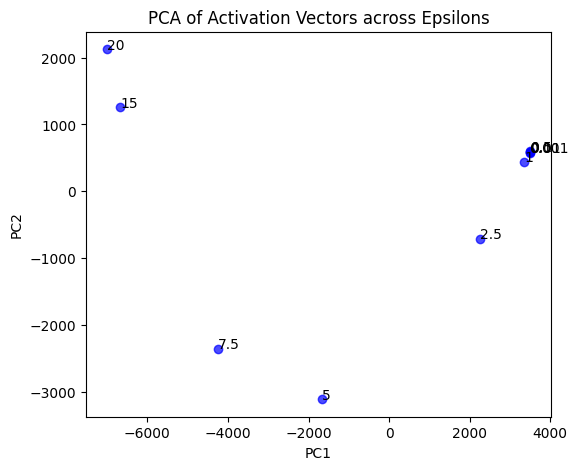

In [535]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Suppose intervened_index_counts is your activation count matrix:
#   shape [num_samples, num_features], e.g. [10, 32768]
X = intervened_index_counts  # shape: [10, 32768]

# Convert to numpy if needed:
X_np = X.cpu().numpy()  # or just X.numpy() if already on CPU

# Fit PCA with 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)  # shape: [10, 2]


# Plot the 2D PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.7)

# Annotate each point with epsilon (if you have 10 data points, be sure epsilons has length 10)
for i, eps in enumerate(epsilons):
    plt.annotate(str(eps), (X_pca[i, 0], X_pca[i, 1]))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Activation Vectors across Epsilons")
plt.show()


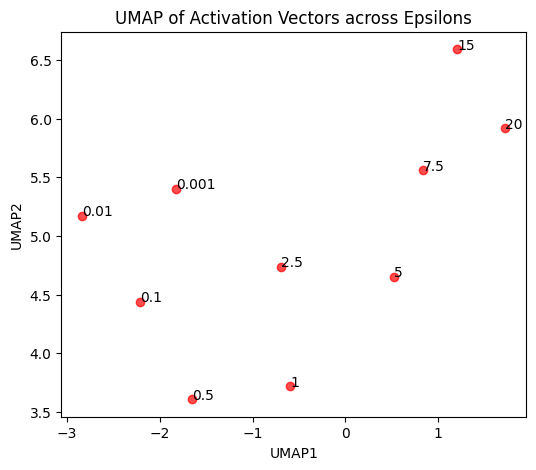

In [536]:
import umap.umap_ as umap

X_np = X.cpu().numpy()

# Configure UMAP
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
X_umap = reducer.fit_transform(X_np)  # shape: [10, 2]

plt.figure(figsize=(6,5))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c='red', alpha=0.7)

for i, eps in enumerate(epsilons):
    plt.annotate(str(eps), (X_umap[i, 0], X_umap[i, 1]))

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of Activation Vectors across Epsilons")
plt.show()


# EXTRA

In [432]:
np.argmax(latent_activations.cpu().numpy())

11075

In [337]:
latent_activations.shape

torch.Size([32768])

In [341]:
latent_activations = latent_intervened_activations

In [354]:
# accumulator = torch.zeros_like(latent_activations)  # assuming first dimension is batch
# index_counts = torch.zeros_like(latent_activations, dtype=torch.int)
# weighted_counts = torch.zeros(32768, dtype=torch.float).to(device)


# # In your loop
# for i in range(len(embeddings)):
#     latent_activations, latent_intervened_activations = get_latent_activations(embeddings[i], intervened_embeddings[i])
    
#     # Add 1 where there are non-zero values
#     index_counts += (latent_activations != 0).int()

#     weighted_counts += latent_activations.abs()  # using absolute values

In [343]:
# Now index_counts contains how many times each index had a non-zero value
total_activations = index_counts.sum().item()
print(f"Total number of activations across all indices: {total_activations}")

# You can also see which indices were most frequently activated
most_active_indices = torch.argsort(index_counts, descending=True)
print("\nMost frequently activated indices:")
for idx in most_active_indices[:20]:  # Show top 10
    count = index_counts[idx].item()
    print(f"Index {idx}: activated {count} times")

Total number of activations across all indices: 72320

Most frequently activated indices:
Index 30383: activated 2230 times
Index 796: activated 2075 times
Index 5895: activated 2030 times
Index 31852: activated 2015 times
Index 17540: activated 1920 times
Index 28757: activated 1665 times
Index 7144: activated 1630 times
Index 23105: activated 1295 times
Index 18003: activated 1285 times
Index 10532: activated 1270 times
Index 17272: activated 1145 times
Index 3216: activated 1135 times
Index 6911: activated 1120 times
Index 32374: activated 1100 times
Index 12780: activated 1045 times
Index 16759: activated 1030 times
Index 1738: activated 975 times
Index 1924: activated 965 times
Index 29511: activated 960 times
Index 12551: activated 935 times


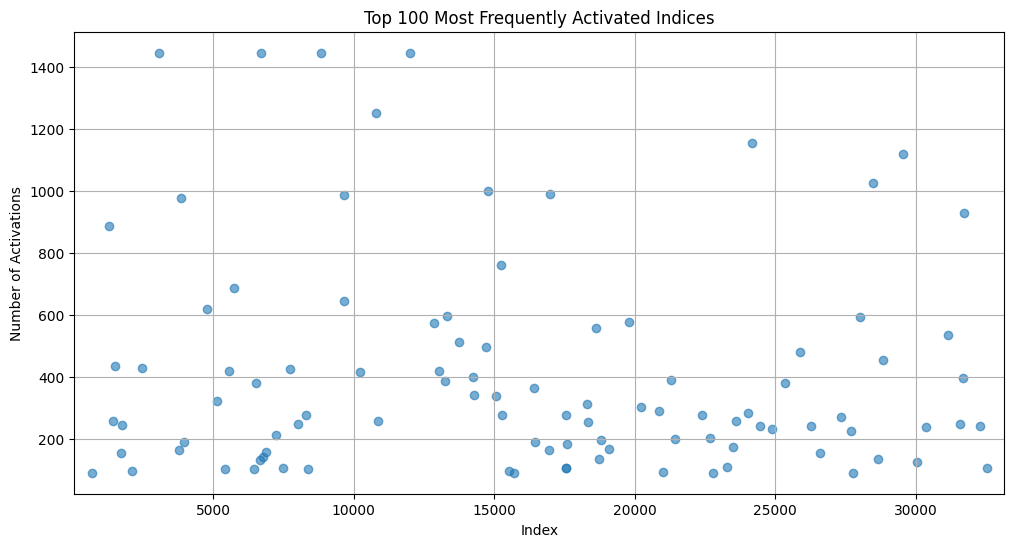

In [93]:
# Get top 100 most active indices and their counts
top_k = 100
top_indices = torch.argsort(index_counts, descending=True)[:top_k]
top_counts = index_counts[top_indices]

# Convert to numpy for plotting
indices = top_indices.cpu().numpy()
counts = top_counts.cpu().numpy()

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(indices, counts, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Number of Activations')
plt.title(f'Top {top_k} Most Frequently Activated Indices')
plt.grid(True)

# Add some spacing around the plot
plt.margins(x=0.02)

# Show the plot
plt.show()

## SAE Study

In [94]:
from circuitsvis.activations import text_neuron_activations

In [483]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Chirag")

In [507]:
from einops import rearrange

def get_neuron_activation(token, feature, model, autoencoder, setting="dictionary_basis"):
    with torch.no_grad():
        print(token)
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache["blocks.11.hook_mlp_out"]
        if setting=="dictionary_basis":
            neuron_act_batch = rearrange(neuron_act_batch, "b s n -> (b s) n" )
            act, info  = autoencoder.encode(neuron_act_batch)
            # print(act)
            return act[:, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, autoencoder, setting="dictionary_basis"):
    if isinstance(text, str):
        text = [text]
    
    display_text_list, activation_list = [], []
    for t in text:
        print(t)
        tokens = model.to_tokens(t, prepend_bos=False) if isinstance(t, str) else t
        split_text = model.to_str_tokens(t, prepend_bos=False)
        
        seq_size = tokens.shape[1]
        if seq_size == 1:
            continue
        
        original = get_neuron_activation(tokens, feature, model, autoencoder)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()

        print(original)
        
        for i in range(seq_size):
            ablated_tokens = torch.cat((tokens[:, :i], tokens[:, i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model, autoencoder, setting)[-1]
        
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        # print(display_text_list)
        activation_list += changed_activations.tolist() + [0.0]

        # print(len(activation_list))
    
    activation_list = torch.tensor(activation_list).reshape(-1, 1, 1)

    print(activation_list)
    return text_neuron_activations(tokens=display_text_list, activations=activation_list)


In [508]:
ablate_text([data[0]["causal1"]["orig"]], 11075, model, autoencoder, setting="dictionary_basis")

the author next to the security guard laughs
tensor([[ 1169,  1772,  1306,   284,   262,  2324,  4860, 22051]],
       device='cuda:0')
0.0
tensor([[ 1772,  1306,   284,   262,  2324,  4860, 22051]], device='cuda:0')
tensor([[ 1169,  1306,   284,   262,  2324,  4860, 22051]], device='cuda:0')
tensor([[ 1169,  1772,   284,   262,  2324,  4860, 22051]], device='cuda:0')
tensor([[ 1169,  1772,  1306,   262,  2324,  4860, 22051]], device='cuda:0')
tensor([[ 1169,  1772,  1306,   284,  2324,  4860, 22051]], device='cuda:0')
tensor([[ 1169,  1772,  1306,   284,   262,  4860, 22051]], device='cuda:0')
tensor([[ 1169,  1772,  1306,   284,   262,  2324, 22051]], device='cuda:0')
tensor([[1169, 1772, 1306,  284,  262, 2324, 4860]], device='cuda:0')
tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]])


In [500]:
def ex(text):# Convert input text into tokens

    if isinstance(text, str):
        text = [text]
    
    display_text_list, activation_list = [], []
    for t in text:
        print(t)
        tokens = model.to_tokens(t, prepend_bos=False) if isinstance(t, str) else t
        split_text = model.to_str_tokens(t, prepend_bos=False)
        
        seq_size = tokens.shape[1]
        if seq_size == 1:
            continue

        with torch.no_grad():
            logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)

        # Extract activations from a specific layer
        input_tensor_ln = activation_cache["blocks.10.hook_resid_post"]

        with torch.no_grad():
            latent_activations, info = autoencoder.encode(input_tensor_ln)
        
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        # print(display_text_list)
        activation_list += latent_activations.tolist() + [0.0]

        # print(len(activation_list))
    
    activation_list = torch.tensor(activation_list).reshape(-1, 1, 1)
    return text_neuron_activations(tokens=display_text_list, activations=activation_list)


ex(data[0]["causal1"]["orig"])

the author next to the security guard laughs


TypeError: not a sequence

In [100]:
def get_neuron_activation(token, feature, model, autoencoder, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache["blocks.11.hook_mlp_out"]
        if setting=="dictionary_basis":
            neuron_act_batch = rearrange(neuron_act_batch, "b s n -> (b s) n" )
            act, info  = autoencoder.encode(neuron_act_batch)
            print(act)
            return act[:, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

In [102]:
embeddings.shape

torch.Size([1446, 768])

In [104]:
latent_activations, info = autoencoder.encode(embeddings)

In [107]:
latent_activations.shape

torch.Size([1446, 32768])

In [ ]:
if isinstance(text, str):
        text = [text]

display_text_list, activation_list = [], []
for t in text:
    tokens = model.to_tokens(t, prepend_bos=False) if isinstance(t, str) else t
    split_text = model.to_str_tokens(t, prepend_bos=False)
    
    seq_size = tokens.shape[1]
    if seq_size == 1:
        continue
    
    original = get_neuron_activation(tokens, feature, model, autoencoder)[-1]
    changed_activations = torch.zeros(seq_size, device=device).cpu()
    
    for i in range(seq_size):
        ablated_tokens = torch.cat((tokens[:, :i], tokens[:, i+1:]), dim=1)
        changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model, autoencoder, setting)[-1]
    
    changed_activations -= original
    display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
    activation_list += changed_activations.tolist() + [0.0]

activation_list = torch.tensor(activation_list).reshape(-1, 1, 1)
text_neuron_activations(tokens=display_text_list, activations=activation_list)

# Explore Indirect object Identification

In [5]:
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [6]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


In [27]:
# model = HookedTransformer.from_pretrained("gpt2-large", center_writing_weights=False)

In [8]:
print_gpu_memory()

Total GPU memory: 8113.81 MB
Allocated GPU memory: 655.09 MB
Cached GPU memory: 700.00 MB


In [9]:
model.blocks

ModuleList(
  (0-11): 12 x TransformerBlock(
    (ln1): LayerNormPre(
      (hook_scale): HookPoint()
      (hook_normalized): HookPoint()
    )
    (ln2): LayerNormPre(
      (hook_scale): HookPoint()
      (hook_normalized): HookPoint()
    )
    (attn): Attention(
      (hook_k): HookPoint()
      (hook_q): HookPoint()
      (hook_v): HookPoint()
      (hook_z): HookPoint()
      (hook_attn_scores): HookPoint()
      (hook_pattern): HookPoint()
      (hook_result): HookPoint()
    )
    (mlp): MLP(
      (hook_pre): HookPoint()
      (hook_post): HookPoint()
    )
    (hook_attn_in): HookPoint()
    (hook_q_input): HookPoint()
    (hook_k_input): HookPoint()
    (hook_v_input): HookPoint()
    (hook_mlp_in): HookPoint()
    (hook_attn_out): HookPoint()
    (hook_mlp_out): HookPoint()
    (hook_resid_pre): HookPoint()
    (hook_resid_mid): HookPoint()
    (hook_resid_post): HookPoint()
  )
)

In [10]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [11]:
for data_pt in data[:1000]:
    prompt = data_pt['causal']['orig']
    index = -1
    str_tokens = model.to_str_tokens(prompt)
    if " has" in str_tokens or " have" in str_tokens:
        try:
            index = str_tokens.index(" has")
        except:
            try:
                index = str_tokens.index(" have")
            except ValueError:
                print("error")
    if index == 14:
        print(prompt)
        print(len(str_tokens))

a 2002 report , by the maritimes province higher education commission has shown that `` after graduation , while male residents do tend to leave at greater rates than female residents from new brunswick , the gap is not statistically significant one year after graduation .
50
aaron 's fellow missionary , paul ryder , has a cycling accident .
19
a bank statement or account statement is a summary of financial transactions which have occurred over a given period of time on a bank account held by a person or business with a financial institution .
37
a behind the scenes programming library , nothing suggests that this software product has any historical , technical , or cultural significance .
24
aberdeen railway station is on the main uk rail network and has frequent direct trains to major cities such as edinburgh , glasgow and london , including the overnight caledonian sleeper train .
42


In [12]:
prompts = [
    "a 10-year-old pokémon trainer , his dream",
    "a 10-year-old pokémon trainer , his dreams",
    "a1 pod is also one of the few pods whose winter grounds",
    "a1 pod is also one of the few pods whose winter ground",
    "abandoning his previously detailed style , his smaller studies from nature",
    "abandoning his previously detailed style , his smaller study from nature",
    "a 2002 report , by the maritimes province higher education commission",
    "a busy street in a major city is by far more likely to",
    "aberdeen railway station is on the main uk rail network and",
    "aberdeen railway stations are on the main uk rail network and"
]

# List of answers, in the format (correct, incorrect)
answers = [
    ("is", "are"),
    ("are", "is"),
    ("are", "is"),
    ("is", "are"),
    ("are", "is"),
    ("is", "are"),
    ("has", "have"),
    ("have", "has"),
    ("has", "have"),
    ("have", "has"),
]
answer_tokens = []
for ans in answers:
    answer_tokens.append(
        (
            model.to_single_token(ans[0]),
            model.to_single_token(ans[1]),
        )
    )

In [13]:
answer_tokens = torch.tensor(answer_tokens).to(device)
answer_tokens

tensor([[  271,   533],
        [  533,   271],
        [  533,   271],
        [  271,   533],
        [  533,   271],
        [  271,   533],
        [10134, 14150],
        [14150, 10134],
        [10134, 14150],
        [14150, 10134]], device='cuda:0')

In [14]:
# example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
# example_answer = " Mary"
# utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [15]:
# prompt_format = [
#     "When John and Mary went to the shops,{} gave the bag to",
#     "When Tom and James went to the park,{} gave the ball to",
#     "When Dan and Sid went to the shops,{} gave an apple to",
#     "After Martin and Amy went to the park,{} gave a drink to",
# ]
# names = [
#     (" Mary", " John"),
#     (" Tom", " James"),
#     (" Dan", " Sid"),
#     (" Martin", " Amy"),
# ]
# # List of prompts
# prompts = []
# # List of answers, in the format (correct, incorrect)
# answers = []
# # List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
# answer_tokens = []
# for i in range(len(prompt_format)):
#     for j in range(2):
#         answers.append((names[i][j], names[i][1 - j]))
#         answer_tokens.append(
#             (
#                 model.to_single_token(answers[-1][0]),
#                 model.to_single_token(answers[-1][1]),
#             )
#         )
#         # Insert the *incorrect* answer to the prompt, making the correct answer the indirect object.
#         prompts.append(prompt_format[i].format(answers[-1][1]))
# answer_tokens = torch.tensor(answer_tokens).to(device)
# print(prompts)
# print(answers)

In [16]:
# answer_tokens

In [17]:
for prompt in prompts:
    str_tokens = model.to_str_tokens(prompt)
    print("Prompt length:", len(str_tokens))
    print("Prompt as tokens:", str_tokens)

Prompt length: 14
Prompt as tokens: ['<|endoftext|>', 'a', ' 10', '-', 'year', '-', 'old', ' p', 'oké', 'mon', ' trainer', ' ,', ' his', ' dream']
Prompt length: 14
Prompt as tokens: ['<|endoftext|>', 'a', ' 10', '-', 'year', '-', 'old', ' p', 'oké', 'mon', ' trainer', ' ,', ' his', ' dreams']
Prompt length: 14
Prompt as tokens: ['<|endoftext|>', 'a', '1', ' pod', ' is', ' also', ' one', ' of', ' the', ' few', ' pods', ' whose', ' winter', ' grounds']
Prompt length: 14
Prompt as tokens: ['<|endoftext|>', 'a', '1', ' pod', ' is', ' also', ' one', ' of', ' the', ' few', ' pods', ' whose', ' winter', ' ground']
Prompt length: 14
Prompt as tokens: ['<|endoftext|>', 'ab', 'andon', 'ing', ' his', ' previously', ' detailed', ' style', ' ,', ' his', ' smaller', ' studies', ' from', ' nature']
Prompt length: 14
Prompt as tokens: ['<|endoftext|>', 'ab', 'andon', 'ing', ' his', ' previously', ' detailed', ' style', ' ,', ' his', ' smaller', ' study', ' from', ' nature']
Prompt length: 14
Prompt a

In [18]:
tokens = model.to_tokens(prompts, prepend_bos=True)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

In [19]:
original_logits.shape

torch.Size([10, 14, 50257])

In [20]:
original_logits[:, -1, :].gather(dim=-1, index=answer_tokens)

tensor([[ 5.4365, -0.5880],
        [ 3.2851,  3.5690],
        [ 6.8082,  4.7452],
        [ 5.3086,  2.1240],
        [ 4.1091,  2.8296],
        [ 4.5323,  2.3671],
        [ 4.0524,  0.9085],
        [ 6.9330, -0.2996],
        [ 5.2134,  0.6928],
        [ 4.7925,  2.6075]], device='cuda:0')

In [21]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


print(
    "Per prompt logit difference:",
    logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(logits_to_ave_logit_diff(original_logits, answer_tokens).item(), 3),
)

Per prompt logit difference: tensor([ 6.0240, -0.2840,  2.0630,  3.1850,  1.2790,  2.1650,  3.1440,  7.2330,
         4.5210,  2.1850])
Average logit difference: 3.152


In [22]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([10, 2, 768])
Logit difference directions shape: torch.Size([10, 768])


In [23]:
logit_diff_directions.shape

torch.Size([10, 768])

In [24]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
final_residual_stream = cache["resid_post", -1]
print("Final residual stream shape:", final_residual_stream.shape)
final_token_residual_stream = final_residual_stream[:, -1, :]
# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(
    final_token_residual_stream, layer=-1, pos_slice=-1
)

average_logit_diff = einsum(
    "batch d_model, batch d_model -> ",
    scaled_final_token_residual_stream,
    logit_diff_directions,
) / len(prompts)
print("Calculated average logit diff:", round(average_logit_diff.item(), 3))
print("Original logit difference:", round(original_average_logit_diff.item(), 3))

Final residual stream shape: torch.Size([10, 14, 768])
Calculated average logit diff: 3.152
Original logit difference: 3.152


## Logit lens

In [ ]:
nonzero_latent = (latent_activations != 0).nonzero()
nonzero_intervened = (latent_intervened_activations != 0).nonzero()

In [ ]:
# Find overlapping indices
overlap = set([tuple(idx.tolist()) for idx in nonzero_latent]) & set([tuple(idx.tolist()) for idx in nonzero_intervened])

print(f"Number of non-zero indices in original: {len(nonzero_latent)}")
print(f"Number of non-zero indices in intervened: {len(nonzero_intervened)}")
print(f"Number of overlapping indices: {len(overlap)}")

# Calculate percentage overlap
overlap_percent = len(overlap) / len(nonzero_latent) * 100
print(f"Percentage overlap: {overlap_percent:.2f}%")

Number of non-zero indices in original: 32
Number of non-zero indices in intervened: 32
Number of overlapping indices: 26
Percentage overlap: 81.25%


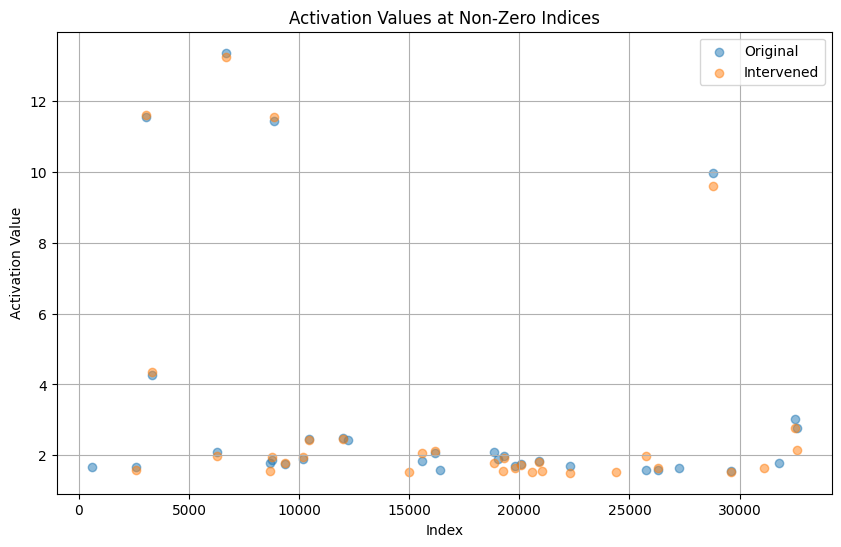

In [ ]:
import matplotlib.pyplot as plt

# Get non-zero indices and their values
nonzero_latent = (latent_activations != 0).nonzero().cpu()
nonzero_intervened = (latent_intervened_activations != 0).nonzero().cpu()

# Get the values at those indices
latent_values = latent_activations[nonzero_latent].cpu()
intervened_values = latent_intervened_activations[nonzero_intervened].cpu()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nonzero_latent, latent_values, alpha=0.5, label='Original')
plt.scatter(nonzero_intervened, intervened_values, alpha=0.5, label='Intervened')

plt.xlabel('Index')
plt.ylabel('Activation Value')
plt.title('Activation Values at Non-Zero Indices')
plt.legend()
plt.grid(True)
plt.show()